###  Logistic Regression Task

기계 센서 데이터를 통해 고장 여부를 예측하는 분류기를 모델화한다.

In [54]:
import pandas as pd


m_df = pd.read_csv('./dataset/machine.csv')
m_df


,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
0,1551,42.8,0,0,0,0,0,0
1,1408,46.3,3,0,0,0,0,0
2,1498,49.4,5,0,0,0,0,0
3,1433,39.5,7,0,0,0,0,0
4,1408,40.0,9,0,0,0,0,0
...,...,...,...,...,...,...,...,...
9810,1604,29.5,14,0,0,0,0,0
9811,1632,31.8,17,0,0,0,0,0
9812,1645,33.4,22,0,0,0,0,0
9813,1408,48.5,25,0,0,0,0,0


In [76]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(features):
    vif = pd.DataFrame()
    vif['vif_score'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif['feature'] = features.columns
    return vif

In [77]:
get_vif(features)

,vif_score,feature
0,12.361460,Rotational speed [rpm]
1,11.143378,Torque [Nm]
2,4.008140,Tool wear [min]
3,1.018994,TWF
4,1.035610,HDF
5,1.039075,PWF
6,1.075163,OSF


In [79]:
m_df = m_df.drop(labels=['Rotational speed [rpm]', 'Torque [Nm]'], axis=1)

In [80]:
from statsmodels.api import OLS

features, targets = m_df.iloc[:, :-1], m_df.iloc[:, -1]

model = OLS(targets, features)
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:        Machine failure   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                          2.086e+04
Date:                Wed, 08 May 2024   Prob (F-statistic):                        0.00
Time:                        16:37:58   Log-Likelihood:                          15466.
No. Observations:                9815   AIC:                                 -3.092e+04
Df Residuals:                    9810   BIC:                                 -3.089e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

array([[<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>,
        <Axes: title={'center': 'Tool wear [min]'}>],
       [<Axes: title={'center': 'TWF'}>, <Axes: title={'center': 'HDF'}>,
        <Axes: title={'center': 'PWF'}>],
       [<Axes: title={'center': 'OSF'}>,
        <Axes: title={'center': 'Machine failure'}>, <Axes: >]],
      dtype=object)

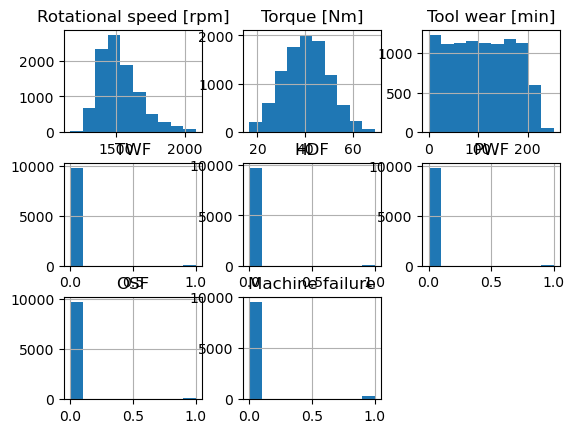

In [55]:
m_df.hist()

In [56]:
m_df['Machine failure'].value_counts()

Machine failure
0    9529
1     286
Name: count, dtype: int64

In [85]:
output0 = m_df[m_df['Machine failure'] == 0].sample(286, random_state=124)
output1 = m_df[m_df['Machine failure'] == 1]


m_df = pd.concat([output0, output1]).reset_index(drop=True)
m_df

,Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
0,51,0,0,0,0,0
1,60,0,0,0,0,0
2,166,0,0,0,0,0
3,149,0,0,0,0,0
4,93,0,0,0,0,0
...,...,...,...,...,...,...
567,238,0,0,0,1,1
568,12,0,0,1,0,1
569,187,0,0,0,1,1
570,206,0,0,0,1,1


In [58]:
import torch
from torch.nn import Sequential, Linear, Sigmoid
from torch.nn.functional import binary_cross_entropy
from sklearn.model_selection import train_test_split
import torch
from torch.optim import SGD
import numpy as np
from torch.nn.functional import binary_cross_entropy

torch.manual_seed(124)

features, targets = m_df.iloc[:, :-1], m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=124)

X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values).view(-1, 1)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values).view(-1, 1)

logistic_r = Sequential(
    Linear(7, 1), # 13개 input을 통해 결과 출력
    Sigmoid(),
)

optimizer = SGD(logistic_r.parameters(), lr=0.00000001)

epochs = 100000

for epoch in range(1, epochs + 1):
    H = logistic_r(X_train)

    loss = binary_cross_entropy(H, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10000 == 0:
        print(f'Epoch: {epoch}/{epochs}')
        for i, w in enumerate(list(logistic_r.parameters())[0][0]):
            print(f'W{i + 1}: {np.round(w.item(), 4)}', end=', ')
        print(f'b: {np.round(list(logistic_r.parameters())[1].item())}\nLoss: {np.round(loss.item(), 4)}')
        print('=' * 90)

Epoch: 10000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0
Loss: 2.9165
Epoch: 20000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0
Loss: 2.9165
Epoch: 30000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0
Loss: 2.9165
Epoch: 40000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0
Loss: 2.9165
Epoch: 50000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0
Loss: 2.9165
Epoch: 60000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0
Loss: 2.9165
Epoch: 70000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0
Loss: 2.9165
Epoch: 80000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def get_evaluation(y_test, prediction, classifier=None, X_test=None):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test , prediction)
    precision = precision_score(y_test , prediction)
    recall = recall_score(y_test , prediction)
    f1 = f1_score(y_test, prediction)
    auc = roc_auc_score(y_test, prediction)
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, ROC-AUC: {4:.4f}'.format(accuracy, precision, recall, f1, auc))
    print("#" * 80)
    
    if classifier is not None and  X_test is not None:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

In [73]:
get_evaluation(y_test.detach(), logistic_r(X_test) >= 0.5)

AttributeError: 'Series' object has no attribute 'detach'

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

features, targets = m_df.iloc[:, :-1], m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=124)

# 일반적으로 데이터 세트가 작을 경우 liblinear의 성능이 좋고, 큰 경우 'sag', 'saga'가 더 좋다.
# 다중 분류는 'newton-cg', 'sag', 'saga', 'lbfgs'만 처리할 수 있다.
logistic_r = LogisticRegression(solver='liblinear', penalty='l2', C=1, random_state=124)
logistic_r.fit(X_train, y_train)
prediction = logistic_r.predict(X_test)

오차 행렬
[[58  0]
 [ 0 57]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 1.0000, F1: 1.0000, ROC-AUC: 1.0000
################################################################################


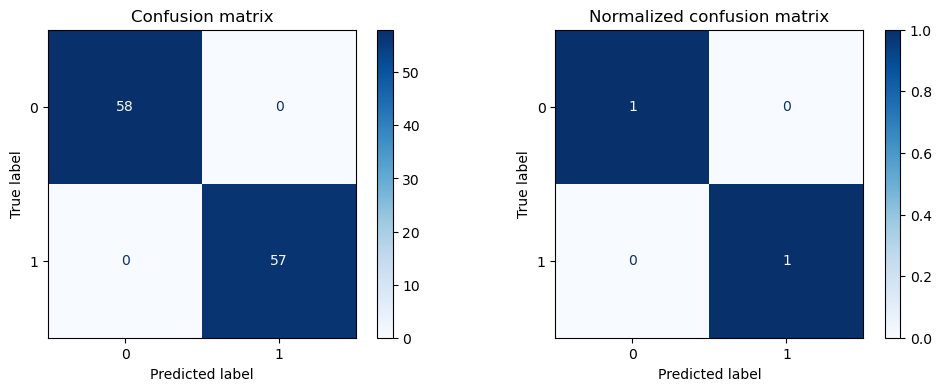

In [87]:
get_evaluation(y_test, prediction, logistic_r, X_test)